### 一.原理介绍
这一节介绍基于密度聚类的代表DBSCAN（Density-Based Spatial Clustering of Applications with Noise）,它的思路也很直观自然，即将高密度聚集的样本看做一个簇，定义高密度，必然要考虑两个指标：   

（1）距离：只有距离近才有可能形成高密度区域；   

（2）数量：只有样本达到一定的量才有意义，比如两个点虽然相距很近，但说这两个点是高密度区域确有些迁强；   

所以，DBSCAN定义了两个超参数$(\epsilon,min\_sample)$对簇做约束：$\epsilon$用于控制距离，$min\_sample$用于控制数量，然后在此超参数的基础上，我们进一步定义另外几个概念，方便我们后续的算法推导，假设我们有样本$D={x_1,x_2,...,_m}$

#### $\epsilon-$领域
对$x_j\in D$，其$\epsilon-$领域表示与其距离在$\epsilon$内的其他样本点所组成的集合，表示为$N_{\epsilon}(x_j)=\{x_i\in D\mid dist(x_i,x_j)\leq \epsilon\}$
#### 核心对象
若样本点的$\epsilon-$领域至少包含$min\_sample$，即$\left|N_{\epsilon}(x_j)\right|\geq min\_sample$，则该样本$x_j$就是一个核心对象
#### 密度直达
若$x_j$位于$x_i$的$\epsilon-$领域内，且$x_i$是核心对象，则称$x_j$由$x_i$密度直达（注意有两个前提条件）
#### 密度可达
若存在样本序列$x_{q_1},x_{q_2},...,x_{q_k}$，使得如下关系存在   

$$
x_i\rightarrow x_{q_1}\rightarrow x_{q_2}\rightarrow\cdots \rightarrow x_{q_k}\rightarrow x_j
$$  

其中，$x_p\rightarrow x_q$表示$x_q$由$x_p$密度直达，那么称$x_j$由$x_i$密度可达

#### 密度相连
对$x_i$与$x_j$，若存在$x_k$使得$x_i$与$x_j$均由$x_k$密度可达，则称$x_i$与$x_j$密度相连

如下图，虚线表示$\epsilon-$领域，$x_1$是核心对象（$min\_sample=3$），$x_2$由$x_1$密度直达，$x_3$由$x_1$密度可到，$x_3$与$x_4$密度相连
![avatar](./source/18_聚类_DBSCAN1.png)

那么，基于这些定义如何去造一个簇呢？DBSCAN的定义是：由密度可达关系导出的最大的密度相连样本集合。这句话读起来拗口，翻译成直白话就是：   

**以核心对象为圆心，$\epsilon$为半径(欧氏距离)，画一个超圆，若超圆内的其他点也是核心对象，那么继续以该点为圆心，$\epsilon$为半径画超圆,...,直到画不动为止，所有这些超圆内的样本点组成一个簇**  

于是，DBSCAN的思路差不多就有了：   

（1）找出所有的核心节点；   

（2）随机挑一个核心节点，画超圆...画....画...，组成第一个簇（注意：这个簇内还可能包含有其他的核心节点），然后从剩下的核心节点（不在第一个簇中）再随机挑选一个核心节点画超圆...组成第二簇，重复该步骤，直到没有核心节点

需要注意一点的就是，可能存在不在所有簇中的样本点，显然这样的样本点离其他的样本点距离都较远，所以我们可以将这样的点看做是离群点或者异常点

### 二.算法流程

>输入：样本集$D=\{x_1,x_2,...,x_m\}$，领域参数$(\epsilon,min\_sample)$；  

>过程：  

>（1）初始化核心对象集合$H=\{\}$  

>（2）对$j=1,2,...,m$
>> 如果$\left|N_{\epsilon}(x_j)\right|\geq min\_sample$，那么$H=H\bigcup \{x_j\}$  

>（3）初始化聚类簇数$k=0$  

>（4）初始化未访问样本集合$W=D$  

>（5）while $H\neq \{\}$  

>> （5.1）记录当前未访问样本集合$W_{old}=W$  

>> （5.2）随机选择一个核心对象$o\in H$，初始化队列$Q=<o>$  

>> （5.3）$W=W/ \{o\}$   

>> （5.4）while $Q\neq <>$  

>>> （5.4.1）取出队列$Q$中的首个样本$q$；   

>>> （5.4.2）如果$\left|N_{\epsilon}(q)\right|\geq min\_sample$，则：   

>>>> 令$\Delta=\left|N_{\epsilon}(q)\right|\bigcap W$   

>>>> 将$\Delta$中的样本加入队列$Q$；  

>>>> $W=W/\Delta$   

>> （5.5）$k=k+1$，生成聚类簇$C_k=W_{old}/W$；   

>> （5.6）$H=H/C_k$   

>输出，簇划分$C=\{C_1,C_2,...,C_k\}$

### 三.代码实现

In [1]:
"""
DBSCAN密度聚类的代码实现，封装到ml_models.cluster
"""
import numpy as np
from queue import Queue


class DBSCAN(object):
    def __init__(self, eps=0.5, min_sample=3, dist_method=None):
        """
        :param eps:epsilon领域半径
        :param min_sample: 核心对象的epsilon领域半径内的最少样本量
        :param dist_method:样本距离度量，默认欧氏距离
        """
        self.eps = eps
        self.min_sample = min_sample
        self.dist_method = dist_method
        if self.dist_method is None:
            self.dist_method = lambda x, y: np.sqrt(np.sum(np.power(x - y, 2)))
        self.label_ = None  # 记录样本标签，-1表示异常点

    def fit(self, X):
        rows = X.shape[0]
        self.label_ = np.ones(rows) * -1
        M = np.zeros(shape=(rows, rows))
        # 计算样本间的距离
        for i in range(rows - 1):
            for j in range(i, rows):
                M[i, j] = self.dist_method(X[i], X[j])
                M[j, i] = M[i, j]
        # 记录核心矩阵
        H = set()
        for i in range(0, rows):
            if np.sum(M[i] <= self.eps) >= self.min_sample:
                H.add(i)
        # 初始化聚类簇数
        k = 0
        # 初始化未访问样本集合
        W = set(range(rows))
        while len(H) > 0:
            # 记录当前未访问样本集合
            W_old = W.copy()
            # 随机选择一个核心对象
            o = np.random.choice(list(H))
            # 初始化队列
            Q = Queue()
            Q.put(o)
            # 未访问队列中去掉核心对象o
            W = W - set([o])
            while not Q.empty():
                # 取出首个样本
                q = Q.get()
                # 判断是否为核心对象
                if q in H:
                    # 获取领域内样本与未访问样本的交集
                    delta = set(np.argwhere(M[q] <= self.eps).reshape(-1).tolist()) & W
                    # 将其放入队列
                    for d in delta:
                        Q.put(d)
                    # 从未访问集合中去掉
                    W = W - delta
            # 获取聚类簇idx
            C_k = W_old - W
            k_idx = list(C_k)
            self.label_[k_idx] = k
            k += 1
            # 去掉在当前簇中的核心对象
            H = H - C_k

    def fit_predict(self, X):
        self.fit(X)
        return self.label_

### 四.测试

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#造伪数据
X, _ = datasets.make_moons(noise=0.01)

In [4]:
#训练
dbscan = DBSCAN(eps=0.2, min_sample=3)
lable = dbscan.fit_predict(X)

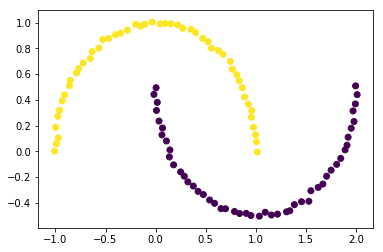

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=lable)
plt.show()